# Problem Set 4: Credit Card Fraud Detection

**Release Date:** 30 September 2022

**Due Date:** 23:59, 22 October 2022

## Overview

In class, we discussed about logistic regression, and how it can be useful as a classification algorithm. In this problem set, we get some hands-on practice by implementing logistic regression on a Credit Card Fraud Detection dataset. Note that for this problem set, you should only be using the scikit-learn (sklearn) library for the last part (Tasks 5.x) on SVM.

**Required Files**:

* ps4.ipynb
* credit_card.csv
* restaurant_data.csv

**Honour Code**: Note that plagiarism will not be condoned! You may discuss with your classmates and check the internet for references, but you MUST NOT submit code/report that is copied directly from other sources!

## Introduction

The context is that there are fraudulent credit card transactions. Therefore, we hope to help credit card companies recognize those fraudulent transactions so that customers are not charged for items that they did not purchase.

We are given a dataset that contains transactions made by credit cards holders in `credit_card.csv`. If we think about what type of data might be included in the input variables under the given context, we might realize that those input variables are likely to include word descriptions, such as shop name or locations. In this problem set, we don't need to worry about language processing as the data are pre-processed to contain only numeric values.

## Getting Started

Take a look at the columns in the dataset `credit_card.csv`. We have V1-V20, 'Amount', and 'Time' as input features, and 'Class' as output which takes the value 1 if it's fraud and 0 otherwise. This dataset presents 492 frauds out of 284,807 transactions. That means, there are 284,808 rows (including the header) in the csv file.

We will use this dataset to implement logistic regression using batch and stochastic gradient descent for binary classification.

In [513]:
# Initial imports and setup

import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn import model_selection

########################
# Read credit card     #
# data for large tests #
########################

dirname = os.getcwd()
credit_card_data_filepath = os.path.join(dirname, 'credit_card.csv')
restaurant_data_filepath = os.path.join(dirname, 'restaurant_data.csv')

credit_df = pd.read_csv(credit_card_data_filepath)
X = credit_df.values[:, :-1]
y = credit_df.values[:, -1:]

## Data Processing

### Task 1.1: Problem with imbalanced data

Our first task is to describe in one or two sentences what problem we might encounter if we directly use the given dataset without processing it. (Hint: consider the 'Class' column, and think about how a high accuracy prediction can be achieved in a wrong way)

### Task 1.2: Resampling methods

When we are faced with the issue of imbalanced data, there are several ways to deal with it. A more direct way might be just to collect more data instances. We realized that in our case this doesn't work well because the events unevenly occur. We then look at how to resample the existing instances.

In this problem set, you are introduced with three resampling methods: undersampling, oversampling, and SMOTE.

#### Concept 1.2.1: Undersampling

<figure>
<img src="imgs/undersampling.png" alt="visualisation of undersampling" width="50%">
<figcaption style="text-align:center">Figure 1: Visualisation of undersampling.</figcaption>
</figure>

The figure above illustrates undersampling. In undersampling, we remove samples from the majority class. More specifically, we randomly take subsamples of the majority class such that the size of two classes is the same.

#### Task 1.2.1: Random undersampling in practice

Your task is to observe the data in credit\_card.csv and randomly remove some observations of the majority class until the two classes balance out.

In [514]:
def random_undersampling(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given credit card dataset with 0 as the majority for 'Class' column. Returns credit card data with two classes
    having the same shape, given raw data read from csv.

    Parameters
    ----------
    df: pd.DataFrame
        The potentially imbalanced dataset.

    Returns
    -------
    Undersampled dataset with equal number of fraudulent and legitimate data.
    '''

    class_0 = df[df['Class'] == 0]
    class_1 = df[df['Class'] == 1]
    class_0_undersampled = class_0.sample(class_1.shape[0])

    return pd.concat([class_0_undersampled, class_1], axis = 0)

In [515]:
def test(df, num):
    data = random_undersampling(df)
    count_0, count_1 = data['Class'].value_counts()
    return count_0 == num and count_1 == num

# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],
        [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
assert test(df1, 3)

# credit card data
assert test(credit_df, 492)

Now you might realize the drawback of undersampling - by removing data randomly, you might have removed some valuable information from the dataset. Is there any way to do better without losing the valuable information?

#### Concept 1.2.2: Oversampling

<figure>
<img src="imgs/oversampling.png" alt="visualisation of oversampling" width="50%">
<figcaption style="text-align:center">Figure 2: Visualisation of oversampling.</figcaption>
</figure>

The figure above illustrates oversampling. In oversampling, we duplicate records of the minority class such that the size of two classes balance out.

#### Task 1.2.2: Oversampling in practice

Your task is to observe the data in credit\_card.csv and apply the oversampling technique to the dataset.

You might realize the bright side of oversampling - you don't lose certain valuable information. At the same time, you also realize the drawback of oversampling - it can cause overfitting and a poor generalization of the test set. Now the question is, instead of simply duplicating records, is there any other way to increase the number of records in the minority set?

In [516]:
def random_oversampling(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given credit card dataset with 0 as the majority for 'Class' column. Returns credit card data with two classes
    having the same shape, given raw data read from csv.

    Parameters
    ----------
    df: pd.DataFrame
        The potentially imbalanced dataset.

    Returns
    -------
    Oversampled dataset with equal number of fraudulent and legitimate data.
    '''

    class_0 = df[df['Class'] == 0]
    class_1 = df[df['Class'] == 1]
    class_1_oversampled = class_1.sample(n = class_0.shape[0], replace=True)

    return pd.concat([class_0, class_1_oversampled], axis = 0)

In [517]:
def test(df, num):
    data = random_oversampling(df)
    count_0, count_1 = data['Class'].value_counts()
    return count_0 == num and count_1 == num

# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],
        [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
assert test(df1, 6)

# credit card data
assert test(credit_df, 284315)

#### Concept 1.2.3: SMOTE (for further reading only)

<figure>
<img src="imgs/smote.png" alt="visualisation of SMOTE" width="50%">
<figcaption style="text-align:center">Figure 3: Visualisation of SMOTE.</figcaption>
</figure>

The figure above illustrates Synthetic Minority Oversampling Technique (SMOTE).

The SMOTE algorithm works in these four steps:

1. Consider minority and majority instances in vector space.
1. For each minority-class instance pair, interpolate their feature values.
1. Randomly synthesize instances and label with minority class
1. More instances added to minority class

In this case, you increase the number of minority instances without simply duplicating the values. Now your newly inserted minority record is not an exact copy of an existing data point, but it is also not too different from the known observations in your minority class. Outside this problem set, when we want to do data resampling, we can use the [Python imbalanced-learn library](https://pypi.org/project/imbalanced-learn/). We will not be implementing SMOTE algorithm for this problem set.

#### Word of caution when resampling

In the section above, we introduced three resampling techniques. One very important thing to note is, in practice you should first split dataset to train–test sets, then resample train and test datasets separately. This is done to avoid data leakage (snooping).

Data leakage can cause you to create overly optimistic if not completely invalid predictive models. It is when information from outside the training dataset is used to train the model. The additional information might allow the model to learn something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

## Splitting data

Before we can start training our models, we need to **randomly** partition our dataset into training data and testing data. Remember that we are trying to make a model that can predict fraudulence of data points that the model has never seen. It would be unwise to measure the accuracy of the model using the same data it trained on.

### Task 2.1: Splitting data

In this task, you need to implement `train_test_split`. This function takes `X`, `y`, and `test_size` as arguments, and output `X_train`, `X_test`, `y_train`, and `y_test` you obtained.

In [518]:
def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float=0.25):
    '''
    Randomly split the data into two sets.

    Parameters
    ----------
    X: np.ndarray
        (m, n) dataset (features).
    y: np.ndarray
        (m,) dataset (corresponding targets).
    test_size: np.float64
        fraction of the dataset to be put in the test dataset.

    Returns
    -------
    A tuple of four elements (X_train, X_test, y_train, y_test):
    X_train: np.ndarray
        (m - k, n) training dataset (features).
    X_test: np.ndarray
        (k, n) testing dataset (features).
    y_train: np.ndarray
        (m - k,) training dataset (corresponding targets).
    y_test: np.ndarray
        (k,) testing dataset (corresponding targets).
    '''

    m = X.shape[0]
    k = int(m * test_size) # number of datapoints in test_set
    y = np.reshape(y, (1, m))
    
    Xy = np.concatenate((X, y.T), axis = 1)
    np.random.shuffle(Xy)

    X_test = Xy[:k, :-1]
    y_test = Xy[:k, -1]
    X_train = Xy[k:, :-1]
    y_train = Xy[k:, -1]

    return X_train, X_test, y_train, y_test

In [519]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1 = [7, 2, 7, 2]
def test_train_test_split(X, y, test_size = 0.25, expected = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size)
    return len(X_train) == expected[0] and len(X_test) == expected[1] and len(y_train) == expected[2] and len(y_test) == expected[3]
assert test_train_test_split(X1, y1, expected = expected1)

## Logistic regression

### Gradient descent

Recall the gradient descent method you learned and applied in the previous problem set. Gradient descent is an iterative optimization method which finds the minimum of a differentiable function. It's often used to find the coefficients that minimize the cost function. Here is a brief recap of how that's done:

<figure>
<img src="imgs/gradient_descent.png" alt="visualisation of gradient descent" width="50%">
</figure>

[Figure 4: Visualisation of gradient descent.](https://medium.com/@divakar_239/stochastic-vs-batch-gradient-descent-8820568eada1)

We start at an initial weight vector $(w_0, w_1, ..., w_n)$. Then we take incremental steps along the steepest slope to get to the bottom where the minimum cost lies. Along the way, we keep updating the weight coefficients by computing the gradients using the training samples from the training dataset.

### Concept: Batch gradient descent

In batch gradient descent, all the training data (entire batch) is taken into consideration in a single step. For one step of gradient descent, we calculate $- \alpha * gradient$ based on all the training examples and then use that mean gradient to update our parameters.

By continuing this for iterations until convergence, or until it's time to stop, we reach the optimal or near optimal parameters $w$ leading to minimum cost.

### Concept: Stochastic gradient descent

Think about what's a limitation of the (entire) batch gradient descent introduced earlier. What if the dataset is very large? In Stochastic Gradient Descent (SGD), we consider only the error on a single record $(x^{(*)}, y^{(*)})$ at a time. Note that SGD does not necessarily decrease the batch loss in each iteration! However, on average, the loss will still decrease. Since we work on only a single record at any time, SGD provides the advantage of a much smaller memory requirement, and faster computation time. SGD also comes with its own set of disadvantages, for example, we lose benefits of any vectorization.

### Concept: Gradient descent termination condition

The next question is when to stop? The ideal case it to run until convergence, but convergence might be hard to obtain. Here are some criteria you can use:

* Stop when error change is small and/or
* Stop when error is small
* Stop when maximum number of iterations is reached

Now let's try to apply the batch gradient descent and stochastic gradient descent.
Task 3.1 to 3.4 will gradually guide you to complete the logistic regression using batch gradient descent, while task 3.5 expects you to implement the stochastic one. For the task in this problem set, you can assume that the bias column has been added for all input `X`. That means given `X` as an argument, you don't need to manually add the bias column again in your code.

### Task 3.1: Cost function

Recall that for logistic regression, we want an error function for an individual value to be:

<figure>
<img src="imgs/piecewise_error.png" alt="error function" width="50%">
<figcaption style="text-align:center">Figure 5: Cost function.</figcaption>
</figure>

We can remove the condition and transform it into:

<figure>
<img src="imgs/error.png" alt="error function as a line" width="50%">
<figcaption style="text-align:center">Figure 6: Cost without conditions.</figcaption>
</figure>

In this task, you need to implement `cost_function` $E$ as mentioned above. This function takes `X`, `y`, and `weight_vector` $w$ as arguments, and returns the error $E$. Note that for this task, the $E$ should account for all the trianing data.

Here, we are using the log function and we need to handle the case of computing log(0). There are many ways to handle this. In this task, we will handle log(0) using machine epsilon for numpy float64 type, and use the trick log(x + EPS) which allows x to be 0. If x was any other value, log(x + EPS) would be very close to log(x).

In [520]:
def cost_function(X: np.ndarray, y: np.ndarray, weight_vector: np.ndarray):
    '''
    Cross entropy error for logistic regression

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    y: np.ndarray
        (m,) training dataset (corresponding targets).
    weight_vector: np.ndarray
        (n,) weight paramaters.

    Returns
    -------
    Cost
    '''
    m, n = np.shape(X)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    sigmoid_vectorized = np.vectorize(sigmoid)

    weight_vector = np.reshape(weight_vector, (1, n))
    y_pred = sigmoid_vectorized((weight_vector @ X.T)[0])
    
    EPS = np.finfo(np.float64).eps
    cost = np.sum(-y * np.log(y_pred + EPS) - (1 - y) * np.log(1 - y_pred + EPS)) / m

    return cost

In [521]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],
        [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([0.002, 0.1220])
assert np.round(cost_function(X1, y1, w1), 5) == np.round(1.29333, 5)

### Task 3.2: Weight update

In this task, you need to implement `weight_update`. This function takes `X`, `y`, `alpha`, and a `weight_vector` as arguments, and output the new weight vector. Each call to the function should make one update on the weight vector.

In [522]:
def weight_update(X: np.ndarray, y: np.ndarray, alpha: np.float64, weight_vector: np.ndarray) -> np.ndarray:
    '''
    Do the weight update for one step in gradient descent

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    y: np.ndarray
        (m,) training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.
    weight_vector: np.ndarray
        (n,) weight paramaters.

    Returns
    -------
    New weight vector after one round of update.
    '''
    m, n = np.shape(X)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    sigmoid_vectorized = np.vectorize(sigmoid)

    y_pred = ([weight_vector] @ X.T)[0] # WtX
    y_pred = sigmoid_vectorized(y_pred) # apply sigmoid function
    weight_grad = (y_pred - y) @ X / m
    weight_vector = weight_vector - alpha * weight_grad
    return weight_vector

In [523]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [111.6, 10, 1],
        [111.4, 10, 0], [111.5, 10, 1], [111.6, 10, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
w1 = np.transpose([2.2000, 12.20000])
a1 = 1e-5
nw1 = np.array([2.19926,12.19992])
assert (np.round(weight_update(X1, y1, a1, w1), 5) == np.round(nw1, 5)).all()

### Task 3.3: Logistic regression classification

Remember that logistic regression is used for classification even though the function gives a probability output. In this task, you classify each element in `X`, given `weight_vector` using `prob_threshold` as the threshold, and output the classification result as an `np.ndarray`.

If the probability predicted by the `weight_vector` exceeds the `prob_threshold`, we should classify it as fraud (`y = 1`). Otherwise, we should classify it as legitimate (`y = 0`).

In [524]:
def logistic_regression_classification(X: np.ndarray, weight_vector: np.ndarray, prob_threshold: np.float64=0.5):
    '''
    Do classification task using logistic regression.

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features).
    weight_vector: np.ndarray
        (n,) weight paramaters.
    prob_threshold: np.float64
        the threshold for a prediction to be considered fraudulent.

    Returns
    -------
    Classification result as an (m,) np.ndarray
    '''
    m, n = np.shape(X)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    sigmoid_vectorized = np.vectorize(sigmoid)
    weight_vector = [weight_vector]
    y_pred = sigmoid_vectorized((weight_vector @ X.T)[0])

    def classify(x):
        if x > prob_threshold:
            return 1
        else:
            return 0

    classify_vectorized = np.vectorize(classify)
    return classify_vectorized(y_pred)
    
    

In [525]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
w1 = np.transpose([-0.000002, 0.000003])
expected1 = np.transpose([0, 0, 0, 0, 0, 0, 0, 1, 0])
def test_classification(X, w, expected):
    res = logistic_regression_classification(X, w)
    return (res == expected).all() and res.shape == expected.shape
assert test_classification(X1, w1, expected1)

### Task 3.4: Logistic regression using batch gradient descent

In this task, you need to implement a fixed learning rate algorithm for logistic regression. This function takes `X_train`, `y_train`, `max_num_epochs`, `threshold`, and `alpha` as arguments, and ouptut the final `weight_vector` you obtained.

In [526]:
def logistic_regression_batch_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int = 250, threshold: np.float64 = 0.05, alpha: np.float64 = 1e-5):
    '''
    Initialize your weight to zeros. Write your terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector. Use that to do predictions, and output the final weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    max_num_epochs: int
        this should be one of the terminating condition. 
        That means if you initialize num_update_rounds to 0, 
        then you should stop updating weight when num_update_rounds >= max_num_epochs.
    threshold: np.float64
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    alpha: np.float64
        logistic regression learning rate.

    Returns
    -------
    The final (n,) weight paramaters
    '''
    m, n = np.shape(X_train)

    weight_vector = np.zeros(n)
    error = cost_function(X_train, y_train, weight_vector)
    num_update_rounds = 0

    while num_update_rounds < max_num_epochs and error > threshold:
        weight_vector = weight_update(X_train, y_train, alpha, weight_vector)
        error = cost_function(X_train, y_train, weight_vector)
        num_update_rounds += 1
        
    return weight_vector

In [527]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
max_num_epochs1 = 20
expected1 = np.transpose([-0.00115, 0.00195])
assert np.array_equal(np.round(logistic_regression_batch_gradient_descent(X1, y1, max_num_epochs1), 5), np.round(expected1, 5))

### Task 3.5: Logistic regression using stochastic gradient descent

In this task, you need to implement logistic regression using stochastic gradient descent. This function takes `X_train`, `y_train`, `max_num_epochs`, `threshold`, and `alpha` as arguments, and output the final `weight_vector` you obtained.

In [528]:
def weight_update_stochastic(X: np.ndarray, y: np.ndarray, alpha: np.float64, weight_vector: np.ndarray) -> np.ndarray:
    '''
    Do the weight update for one step in gradient descent.

    Parameters
    ----------
    X: np.ndarray
        (1, n) training dataset (features).
    y: np.ndarray
        one y in training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.
    weight_vector: np.ndarray
        (n, 1) vector of weight paramaters.

    Returns
    -------
    New (n,) weight paramaters after one round of update.
    '''

    m, n = np.shape(X)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    sigmoid_vectorized = np.vectorize(sigmoid)

    random_index = np.random.randint(0, m) # picks a random datapoint from 0 to m - 1
    random_X = X[random_index]
    random_y = y[random_index]

    y_pred = ([weight_vector] @ random_X.T)[0] # WtX
    y_pred = sigmoid_vectorized(y_pred) # apply sigmoid function
    weights_grad = (y_pred - random_y) * random_X
    weight_vector = weight_vector - alpha * weights_grad
    return weight_vector

In [529]:
def logistic_regression_stochastic_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int=250, threshold: np.float64=0.05, alpha: np.float64=1e-5) -> np.ndarray:
    '''
    Initialize your weight to zeros. Write a terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    max_num_epochs: int
        this should be one of the terminating conditions. 
        The gradient descent step should happen at most max_num_epochs times.
    threshold: np.float64
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    alpha: np.float64
        logistic regression learning rate.

    Returns
    -------
    The final (n,) weight paramaters
    '''

    m, n = np.shape(X_train)

    weight_vector = np.zeros(n)
    error = cost_function(X_train, y_train, weight_vector)
    num_update_rounds = 0

    while num_update_rounds < max_num_epochs and error > threshold:
        weight_vector = weight_update_stochastic(X_train, y_train, alpha, weight_vector)
        error = cost_function(X_train, y_train, weight_vector)
        num_update_rounds += 1
        
    return weight_vector

In [530]:
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1 = cost_function(X1, y1, np.transpose(np.zeros(X1.shape[1])))
def test_stochastic(X, y, expected):
    return cost_function(X, y, logistic_regression_stochastic_gradient_descent(X, y)) < expected
assert test_stochastic(X1, y1, expected1)

### Task 3.6: Stochastic gradient descent vs batch gradient descent

Think about the number of iterations and/or the runtime it takes to run the update in task 3.4 and task 3.5. What do you observe?

### Task 3.7: Plotting

Make a plot you think will be relevant in supporting your observation in 3.6. You can create helper functions if necessary. For your plot, please include the x and y labels. Put both methods (batch gradient descent and stochastic gradient descent) in one diagram.

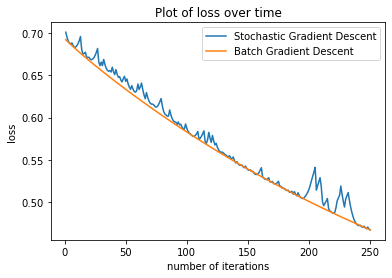

In [531]:
import matplotlib.pyplot as plt

def stochastic_loss_per_iteration(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int=250, threshold: np.float64=0.05, alpha: np.float64=1e-5) -> np.ndarray:

    # this function performs 250 iterations and records the loss at every iteration

    m, n = np.shape(X_train)

    weight_vector = np.zeros(n)
    error = cost_function(X_train, y_train, weight_vector)
    num_update_rounds = 0

    loss_array = []

    while num_update_rounds < max_num_epochs:
        weight_vector = weight_update_stochastic(X_train, y_train, alpha, weight_vector)
        error = cost_function(X_train, y_train, weight_vector)
        loss_array.append(error)
        num_update_rounds += 1
        
    return loss_array

def batch_loss_per_iteration(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int = 250, threshold: np.float64 = 0.05, alpha: np.float64 = 1e-5):

    # this function performs 250 iterations and records the loss at every iteration

    m, n = np.shape(X_train)

    weight_vector = np.zeros(n)
    error = cost_function(X_train, y_train, weight_vector)
    num_update_rounds = 0
    
    loss_array = []

    while num_update_rounds < max_num_epochs:
        weight_vector = weight_update(X_train, y_train, alpha, weight_vector)
        error = cost_function(X_train, y_train, weight_vector)
        loss_array.append(error)
        num_update_rounds += 1
        
    return loss_array

data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()

stochastic_loss = stochastic_loss_per_iteration(X1, y1, 250)
batch_loss = batch_loss_per_iteration(X1, y1, 250)
num_iterations = [i for i in range(1, 251)]

plt.title('Plot of loss over time')
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.plot(num_iterations, stochastic_loss, label = 'Stochastic Gradient Descent')
plt.plot(num_iterations, batch_loss, label = 'Batch Gradient Descent')
plt.legend(loc="upper right")

## Multi-class logistic regression

Now that you have helped the credit card companies recognize fraudulent transactions, customers are less likely to be charged for items that they did not purchase. They are very satisfied with how well your model performed. They want to offer you a meal, at a restaurant of your choice. You decide to make your choice based on the occupancy of the restaurant. Luckily for you, you have some starting data `restaurant_data.csv` to work with. The dataset provides three input features "max_capacity", "feedback_score", and "average_expense", and an ouptut feature "occupancy" that takes the value of "none", "some", or "full".

### Task 4.1: Multi-class logistic regression using batch gradient descent

In this task, you need to implement a fixed learning rate algorithm for multi-class logistic regression. This function takes `X_train`, `y_train`, `max_num_epochs`, `threshold`, `alpha`, and `class_i` as arguments, and output the final `weight_vector` you obtained. Here, argument `class_i` is the class that you want to train in this round.

In [532]:
def multi_class_logistic_regression_batch_gradient_descent(X_train: np.ndarray, y_train: np.ndarray, max_num_epochs: int, threshold: np.float64, alpha: np.float64, class_i: str) -> np.ndarray:
    '''
    Initialize your weight to zeros. Write your terminating condition, and run the weight update for some iterations.
    Get the resulting weight vector. Output the resulting weight vector.

    Parameters
    ----------
    X_train: np.ndarray
        (m, n) training dataset (features).
    y_train: np.ndarray
        (m,) training dataset (corresponding targets).
    alpha: np.float64
        logistic regression learning rate.
    max_num_epochs: int
        this should be one of the terminating condition. 
        That means if you initialize num_update_rounds to 0, 
        then you should stop updating weight when num_update_rounds >= max_num_epochs.
    threshold: float
        terminating when error <= threshold value, or if you reach the max number of update rounds first.
    class_i: string
        one of 'none', 'full', 'some'.

    Returns
    -------
    The final (n,) weight paramaters
    '''

    def none_vs_all(x):
        if x == 'none':
            return 1
        return 0
    none_vectorized = np.vectorize(none_vs_all)
    
    def full_vs_all(x):
        if x == 'full':
            return 1
        return 0
    full_vectorized = np.vectorize(full_vs_all)
    
    def some_vs_all(x):
        if x == 'some':
            return 1
        return 0
    some_vectorized = np.vectorize(some_vs_all)

    if class_i == 'none':
        y_train = none_vectorized(y_train)
    elif class_i == 'full':
        y_train = full_vectorized(y_train)
    elif class_i == 'some':
        y_train = some_vectorized(y_train)
        
    return logistic_regression_batch_gradient_descent(X_train, y_train, max_num_epochs, threshold, alpha)

In [533]:
data1 = [[26, 9, 69, 'full'],
        [54, 3, 16, 'some'],
        [59, 7, 50, 'some' ],
        [33, 0, 45, 'full']]
df1 = pd.DataFrame(data1, columns = ['max_capcity', 'feedback_score', 'average_expense', 'occupancy'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
max_num_epochs1 = 20
expected1 = np.transpose([6.75, 0.125, -6.0])
assert np.array_equal(multi_class_logistic_regression_batch_gradient_descent(X1, y1, max_num_epochs1, 0.05, 1, 'some'), expected1)

### Task 4.2: Do classification on multi-class problem

Finally, you classify each element in `X`, given three weight vectors `weight_vector_none`, `weight_vector_some`, and `weight_vector_full`, and output a list of classification results in the form of an array (`['some', 'none', 'full', 'none', ...]`). Note that in the case of a tie, you can choose the class in the order of priority: `'none'`, `'some'`, `'full'`.

In [534]:
def multi_class_logistic_regression_classification(X: np.ndarray, weight_vector_none: np.ndarray, weight_vector_some: np.ndarray, weight_vector_full: np.ndarray):
    '''
    Do classification task using logistic regression.
    In the case of a tie, break the tie in the priority 'none' > 'some' > 'full'.

    Parameters
    ----------
    X: np.ndarray
        (m, n) training dataset (features)
    weight_vector_none: np.ndarray
        (n,) weight paramaters for the 'none' class.
    weight_vector_some: np.ndarray
        (n,) weight paramaters for the 'some' class.
    weight_vector_full: np.ndarray
        (n,) weight paramaters for the 'full' class.

    Returns
    -------
    Classification result as an (m,) np.ndarray. Eg ['some', 'none', 'full', ... ,'none'].
    '''

    def get_probabilities(X, weight_vector):
        
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))
        sigmoid_vectorized = np.vectorize(sigmoid)

        weight_vector = [weight_vector] # 1 x n
        y_pred = weight_vector @ X.T
        y_pred = sigmoid_vectorized(y_pred)
        return y_pred

    none_probabilities = get_probabilities(X, weight_vector_none)
    some_probabilities = get_probabilities(X, weight_vector_some)
    full_probabilities = get_probabilities(X, weight_vector_full)

    concat_probabilities = np.concatenate((none_probabilities, some_probabilities, full_probabilities), axis = 0)
    final_labels = np.argmax(concat_probabilities, axis = 0) # final labels in the form [1, 0, 1, 2] where 0 is none, 1 is some, 2 is full
    
    def labels_to_string(x):
        if x == 0:
            return 'none'
        elif x == 1:
            return 'some'
        elif x == 2:
            return 'full'
    labels_to_string_vectorized = np.vectorize(labels_to_string)

    return labels_to_string_vectorized(final_labels)

In [535]:
data1 = [[26, 9, 69, 'full'],
        [54, 3, 16, 'some'],
        [59, 7, 50, 'some' ],
        [33, 0, 45, 'full']]
df1 = pd.DataFrame(data1, columns = ['max_capcity', 'feedback_score', 'average_expense', 'occupancy'])
X1 = df1.iloc[:, :-1].to_numpy()

w11 = np.transpose([0.0013351567670329624, 2.5757816929896605e-05, -0.001189020140476165])
w12 = np.transpose([2.5757816929896605e-05, -0.001189020140476165, 0.0013351567670329624])
w13 = np.transpose([2.5757816929896605e-05, 0.0013351567670329624, -0.001189020140476165])
expected1 = np.transpose(['some', 'none', 'some', 'some'])
def test_multi_class_classification(X, w1, w2, w3, expected):
    res = multi_class_logistic_regression_classification(X, w1, w2, w3)
    return res.shape == expected.shape and (res == expected).all()
assert test_multi_class_classification(X1, w11, w12, w13, expected1)

## Support vector machine

Now let's apply the support vector machine we learnt in lecture to the credit card dataset. Here is a quick recap of what SVM is about: We are given a training dataset of $n$ points of the form $(x^{(i)}, y^{(i)})$, where the $y^{(i)}$ are either 1 or 0, each indicating the class to which the point $x^{(i)}$ belongs.

Each $x^{(i)}$ n-dimensional real vector. We want to find the "maximum-margin hyperplane" that divides the group of points $x^{(i)}$ for which $y_{i}=1$ from the group of points for which $y_{i}=0$, which is defined so that the distance between the hyperplane and the nearest point $x^{(i)}$ from either group is maximized.

<figure>
<img src="imgs/svm.png" alt="visualisation of support vector machine" width="50%">
<figcaption style="text-align:center">Figure 7: Visualisation of support vector machine.</figcaption>
</figure>

Then how should we maximize the distance between the data points and hyperplane? To do that, we use hinge loss. We also add a regularization parameter the cost function to balance the margin maximization and loss. Now let's start on implementing the SVM algorithm.

### Task 5.1: Linear SVM

Take a look at the Python library [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) and import it for your use. In this task, the function takes `X`, `y`. Note that here `X` and `y` are not training set but the entire dataset, so you are asked to do a train test data split with `test_size` of 0.3, and `random_state` of 42, **using what's provided in the library** (not what you implemented in task 2.1). Then, create an instance of a Linear SVM classifier using the default parameters, train the Linear SVM classifier, and output the predictions as well as the accuracy score. For this task, you should make full use of the library functions, instead of doing computations on your own.

In [536]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

def linear_svm(X: np.ndarray, y: np.ndarray):
    '''
    Do classification using linear svm. Given X and y, note that here X and y are not training sets, but rather the
    entire dataset. Do a train test data split with test_size=0.3, and random_state=42.

    Parameters
    ----------
    X: np.ndarray
        (m, n) whole dataset (features)
    y: np.ndarray
        (m,) whole dataset (corresponding targets)

    Returns
    -------
    pred: np.ndarray
        The predictions.
    acc: np.float64
        The accuracy on a scale up to 100.
    '''
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=42)
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred) * 100

    return y_pred, accuracy


In [537]:
def test_classification(X, y, expected, expected_accuracy):
    result = linear_svm(X, y)
    return (result[0] == expected).all() and (result[0]).shape == expected.shape and round(result[1], 5) == round(expected_accuracy, 5)

# small data
data1 = [[111.1, 10, 0], [111.2, 20, 0], [111.3, 10, 0], [111.4, 10, 0], [111.5, 10, 0], [211.6, 80, 1],
        [111.4, 10, 0], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1_y = np.transpose([0, 0, 1])
expected1_accuracy = 66.66666666666666
assert test_classification(X1, y1, expected1_y, expected1_accuracy)

# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X = data_100.iloc[:, :-1].to_numpy()
y = data_100.iloc[:, -1].to_numpy()

expected_pred = np.transpose([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
expected_accuracy = 80.0
assert test_classification(X, y.ravel(), expected_pred, expected_accuracy)

### Task 5.2: Gaussian Kernel SVM

Take a look at the Python library [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) and import it for your use. In this task, the function takes `X`, `y`. Note that here `X` and `y` are not training set but the entire dataset, so you are asked to do a train test data split with `test_size` of 0.3, and `random_state` of 42, using what's provided in the library. Then, create an instance of a Gaussian Kernel SVM classifier using the default parameters, train the Gaussian Kernel SVM classifier, and output the predictions as well as the accuracy score. For this task, you should make full use of the library functions, instead of doing computations on your own.

In [538]:
def gaussian_kernel_svm(X: np.ndarray, y: np.ndarray):
    '''
    Do classification using Gaussian Kernel svm. Given X and y, note that here X and y are not training sets, but
    rather the entire dataset. Do a train test data split with test_size=0.3, and random_state=42.

    Parameters
    ----------
    X: np.ndarray
        (m, n) whole dataset (features)
    y: np.ndarray
        (m,) whole dataset (corresponding targets)

    Returns
    -------
    pred: np.ndarray
        The predictions.
    acc: np.float64
        The accuracy on a scale up to 100.
    '''

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=42)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred) * 100

    return y_pred, accuracy

In [539]:
def test_classification(X, y, expected, expected_accuracy):
    result = gaussian_kernel_svm(X, y)
    return (result[0] == expected).all() and (result[0]).shape == expected.shape and round(result[1], 5) == round(expected_accuracy, 5)

# small data
data1 = [[111.1, 10, -1], [111.2, 20, -1], [111.3, 10, -1], [111.4, 10, -1], [111.5, 10, -1], [211.6, 80, 1],
        [111.4, 10, -1], [111.5, 80, 1], [211.6, 80, 1]]
df1 = pd.DataFrame(data1, columns = ['V1', 'V2', 'Class'])
X1 = df1.iloc[:, :-1].to_numpy()
y1 = df1.iloc[:, -1].to_numpy()
expected1_y = np.transpose([-1, -1, 1])
expected1_accuracy = 66.66666666666666
assert test_classification(X1, y1, expected1_y, expected1_accuracy)

# subset of credit card data
class_0 = credit_df[credit_df['Class'] == 0]
class_1 = credit_df[credit_df['Class'] == 1]

data_0 = class_0.sample(n=15, random_state=42)
data_1 = class_1.sample(n=50, random_state=42)
data_100 = pd.concat([data_1, data_0], axis=0)
X = data_100.iloc[:, :-1].to_numpy()
y = data_100.iloc[:, -1].to_numpy()

expected_pred = np.transpose([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
expected_accuracy = 80.0
assert test_classification(X, y.ravel(), expected_pred, expected_accuracy)

### Task 5.3: Linear SVM vs Gaussian Kernel SVM

Based on your observation, when using support vector machine, how do you think we should choose linear kernel vs Gaussian Kernel? In other words, which kernel is better in what cases?

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer,"and click "Save." After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission." Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading.

*Have fun and enjoy coding.*